# Compare Clean vs Degraded MIDI Files

This notebook allows you to interactively compare clean and degraded versions of MIDI files by visualizing their piano rolls side-by-side. You can select different files and variants to explore how various degradations affect the musical content.

## Features:
- Interactive file selection from ACME dataset
- Side-by-side piano roll comparison
- Degradation information display
- Zoom and pan capabilities for detailed inspection

In [28]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display
import warnings

# Import MDTK modules
import sys

sys.path.append("..")
from mdtk import fileio

# Set up plotting style
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
warnings.filterwarnings("ignore")

print("Libraries imported successfully!")

Libraries imported successfully!


## Configuration

Set the path to your ACME dataset directory. By default, it looks for the dataset in the current directory.

In [29]:
# Configuration
DATASET_PATH = Path("/media/scratch/sageev-midi/20250515/degraded01")
# Check if dataset exists
if not DATASET_PATH.exists():
    print(f"⚠️  Dataset not found at {DATASET_PATH}")
    print("Please run make_dataset.py first or update the DATASET_PATH variable.")
    DATASET_PATH = None
else:
    print(f"✅ Dataset found at {DATASET_PATH}")

    # Check for required files
    metadata_file = DATASET_PATH / "metadata.csv"
    degradation_ids_file = DATASET_PATH / "degradation_ids.csv"

    if metadata_file.exists() and degradation_ids_file.exists():
        print("✅ Required metadata files found")
    else:
        print(
            "⚠️  Missing metadata files. Please ensure the dataset was created properly."
        )

✅ Dataset found at /media/scratch/sageev-midi/20250515/degraded01
✅ Required metadata files found


## Load Dataset Metadata

Load the metadata and degradation information from the ACME dataset.

In [30]:
def load_dataset_info(dataset_path):
    """Load metadata and degradation information from ACME dataset."""
    if dataset_path is None:
        return None, None

    # Load metadata
    metadata_df = pd.read_csv(dataset_path / "metadata.csv")

    # Load degradation IDs
    degradation_ids_df = pd.read_csv(dataset_path / "degradation_ids.csv")

    # Create degradation mapping
    degradation_map = dict(
        zip(degradation_ids_df["id"], degradation_ids_df["degradation_name"])
    )

    # Add degradation names to metadata
    metadata_df["degradation_name"] = metadata_df["degradation_id"].map(degradation_map)

    print(f"Loaded {len(metadata_df)} files")
    print(f"Available degradations: {list(degradation_map.values())}")
    print(f"Train/Valid/Test splits: {metadata_df['split'].value_counts().to_dict()}")

    return metadata_df, degradation_map


# Load the dataset
metadata_df, degradation_map = load_dataset_info(DATASET_PATH)

Loaded 11028 files
Available degradations: ['none', 'pitch_shift', 'time_shift', 'onset_shift', 'offset_shift', 'remove_note', 'add_note', 'split_note', 'join_notes']
Train/Valid/Test splits: {'train': 8822, 'valid': 1103, 'test': 1103}


## Piano Roll Visualization Functions

Define functions to create piano roll visualizations from MIDI data.

In [31]:
def load_midi_data(file_path):
    """Load MIDI data from CSV file."""
    print(f"loading: {file_path}")
    if not file_path.exists():
        print(f"File not found: {file_path}")
        return None

    try:
        df = pd.read_csv(file_path)
        # Ensure required columns exist
        required_cols = ["onset", "track", "pitch", "dur", "velocity"]
        if not all(col in df.columns for col in required_cols):
            df.columns = required_cols
        return df
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None


def create_piano_roll(df, title="Piano Roll", ax=None, max_time=None):
    """Create a piano roll visualization from MIDI data."""
    if df is None or len(df) == 0:
        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 8))
        ax.text(
            0.5,
            0.5,
            "No data to display",
            ha="center",
            va="center",
            transform=ax.transAxes,
        )
        ax.set_title(title)
        return ax

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))

    # Calculate note end times
    df = df.copy()
    df["end_time"] = df["onset"] + df["dur"]

    # Set time limit
    if max_time is None:
        max_time = df["end_time"].max()

    # Filter notes within time range
    df_filtered = df[df["onset"] <= max_time].copy()

    # Create piano roll
    for _, note in df_filtered.iterrows():
        start_time = note["onset"]
        end_time = min(note["end_time"], max_time)
        pitch = note["pitch"]
        velocity = note["velocity"]

        # Color based on velocity
        color_intensity = velocity / 127.0
        color = plt.cm.viridis(color_intensity)

        # Draw note as rectangle
        ax.barh(
            pitch,
            end_time - start_time,
            left=start_time,
            height=0.8,
            color=color,
            alpha=0.7,
            edgecolor="black",
            linewidth=0.1,
        )

    # Formatting
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("MIDI Pitch")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

    # Set reasonable y-axis limits based on data
    if len(df_filtered) > 0:
        min_pitch = max(0, df_filtered["pitch"].min() - 5)
        max_pitch = min(127, df_filtered["pitch"].max() + 5)
        ax.set_ylim(min_pitch, max_pitch)

    # Set x-axis limit
    ax.set_xlim(0, max_time)

    return ax


def compare_piano_rolls(
    clean_df, degraded_df, clean_title="Clean", degraded_title="Degraded", max_time=None
):
    """Create side-by-side comparison of piano rolls."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # Determine common time range
    if max_time is None:
        max_times = []
        if clean_df is not None and len(clean_df) > 0:
            max_times.append((clean_df["onset"] + clean_df["dur"]).max())
        if degraded_df is not None and len(degraded_df) > 0:
            max_times.append((degraded_df["onset"] + degraded_df["dur"]).max())
        max_time = max(max_times) if max_times else 5000

    # Create piano rolls
    create_piano_roll(clean_df, clean_title, ax1, max_time)
    create_piano_roll(degraded_df, degraded_title, ax2, max_time)

    # Sync y-axes
    all_pitches = []
    if clean_df is not None and len(clean_df) > 0:
        all_pitches.extend(clean_df["pitch"].tolist())
    if degraded_df is not None and len(degraded_df) > 0:
        all_pitches.extend(degraded_df["pitch"].tolist())

    if all_pitches:
        min_pitch = max(0, min(all_pitches) - 5)
        max_pitch = min(127, max(all_pitches) + 5)
        ax1.set_ylim(min_pitch, max_pitch)
        ax2.set_ylim(min_pitch, max_pitch)

    plt.tight_layout()
    return fig


print("Piano roll functions defined successfully!")

Piano roll functions defined successfully!


## Interactive File Selection and Comparison

Create interactive widgets to select and compare files.

In [ ]:
def create_file_selector(metadata_df, dataset_path):
    """Create interactive widgets for file selection."""
    if metadata_df is None:
        print("No dataset loaded. Please check the dataset path.")
        return None

    # Get unique base filenames (without variant suffixes)
    base_files = []
    for clean_path in metadata_df["clean_csv_path"].unique():
        # Remove variant suffix if present
        base_name = clean_path
        if "_v" in base_name:
            base_name = base_name.split("_v")[0] + ".csv"
        base_files.append(base_name)

    base_files = sorted(list(set(base_files)))

    # Create widgets
    file_selector = widgets.Dropdown(
        options=base_files,
        description="Select File:",
        style={"description_width": "initial"},
        layout=widgets.Layout(width="500px"),
    )

    variant_selector = widgets.Dropdown(
        options=[],
        description="Select Variant:",
        style={"description_width": "initial"},
        layout=widgets.Layout(width="300px"),
    )

    degradation_info = widgets.HTML(
        value="<b>Select a file to see degradation information</b>"
    )

    compare_button = widgets.Button(
        description="Compare Files",
        button_style="primary",
        layout=widgets.Layout(width="150px"),
    )

    output_area = widgets.Output()

    def update_variants(change):
        """Update variant dropdown based on selected file."""
        selected_file = change["new"]
        if not selected_file:
            return

        # Find all variants of this file
        base_name = selected_file.replace(".csv", "")

        # Look for files that match the base name
        matching_rows = metadata_df[
            metadata_df["clean_csv_path"].str.contains(base_name, na=False)
        ]

        if len(matching_rows) == 0:
            variant_selector.options = []
            return

        # Extract variant information - convert to dictionary to avoid pandas issues
        variants = []
        for idx, row in matching_rows.iterrows():
            clean_path = row["clean_csv_path"]
            degradation_name = row["degradation_name"]

            # Extract variant number if present
            if "_v" in clean_path:
                variant_num = clean_path.split("_v")[1].split(".")[0]
                variant_label = f"Variant {variant_num} ({degradation_name})"
            else:
                variant_label = f"Single ({degradation_name})"

            # Convert pandas Series to dictionary to avoid widget validation issues
            row_dict = {
                "clean_csv_path": row["clean_csv_path"],
                "altered_csv_path": row["altered_csv_path"],
                "degradation_name": row["degradation_name"],
                "degraded": row["degraded"],
                "split": row["split"],
                "degradation_id": row["degradation_id"],
            }

            variants.append((variant_label, row_dict))

        variant_selector.options = variants

        # Update degradation info for first variant
        if variants:
            update_degradation_info({"new": variants[0][1]})

    def update_degradation_info(change):
        """Update degradation information display."""
        if change["new"] is None:
            return

        row = change["new"]

        info_html = f"""
        <div style="background-color: #f0f0f0; padding: 10px; border-radius: 5px;">
            <b>File Information:</b><br>
            <b>Clean file:</b> {row['clean_csv_path']}<br>
            <b>Degraded file:</b> {row['altered_csv_path']}<br>
            <b>Degradation:</b> {row['degradation_name']}<br>
            <b>Degraded:</b> {'Yes' if row['degraded'] else 'No'}<br>
            <b>Split:</b> {row['split']}
        </div>
        """

        degradation_info.value = info_html

    def compare_files(button):
        """Compare clean and degraded files."""
        if variant_selector.value is None:
            with output_area:
                print("Please select a file and variant first.")
            return

        row = variant_selector.value

        with output_area:
            output_area.clear_output(wait=True)

            # Load files
            clean_path = dataset_path / row["clean_csv_path"]
            degraded_path = dataset_path / row["altered_csv_path"]

            clean_df = load_midi_data(clean_path)
            degraded_df = load_midi_data(degraded_path)

            if clean_df is None or degraded_df is None:
                print("Error loading files. Please check file paths.")
                return

            # Create comparison
            clean_title = f"Clean: {row['clean_csv_path'].split('/')[-1]}"
            degraded_title = f"Degraded ({row['degradation_name']}): {row['altered_csv_path'].split('/')[-1]}"

            fig = compare_piano_rolls(
                clean_df, degraded_df, clean_title, degraded_title
            )
            plt.show()

            # Print statistics
            print(f"\n📊 Comparison Statistics:")
            print(f"Clean file: {len(clean_df)} notes")
            print(f"Degraded file: {len(degraded_df)} notes")
            print(f"Note difference: {len(degraded_df) - len(clean_df)} notes")

            if len(clean_df) > 0 and len(degraded_df) > 0:
                print(
                    f"\nPitch range (clean): {clean_df['pitch'].min()}-{clean_df['pitch'].max()}"
                )
                print(
                    f"Pitch range (degraded): {degraded_df['pitch'].min()}-{degraded_df['pitch'].max()}"
                )

                clean_duration = (clean_df["onset"] + clean_df["dur"]).max()
                degraded_duration = (degraded_df["onset"] + degraded_df["dur"]).max()
                print(f"Duration (clean): {clean_duration:.0f}ms")
                print(f"Duration (degraded): {degraded_duration:.0f}ms")

    # Set up event handlers
    file_selector.observe(update_variants, names="value")
    variant_selector.observe(update_degradation_info, names="value")
    compare_button.on_click(compare_files)

    # Initial setup
    if base_files:
        file_selector.value = base_files[0]

    return {
        "file_selector": file_selector,
        "variant_selector": variant_selector,
        "degradation_info": degradation_info,
        "compare_button": compare_button,
        "output_area": output_area,
    }


# Create the interface
if metadata_df is not None:
    widgets_dict = create_file_selector(metadata_df, DATASET_PATH)

    if widgets_dict:
        print("Interactive file selector created successfully!")
        print("Use the widgets below to select and compare files.")
    else:
        print("Failed to create file selector.")
else:
    print("No dataset loaded. Please check the DATASET_PATH.")

Interactive file selector created successfully!
Use the widgets below to select and compare files.


## Interactive Comparison Interface

Use the controls below to select and compare clean vs degraded MIDI files.

In [33]:
# Display the interactive interface
if "widgets_dict" in locals() and widgets_dict:
    # Create layout
    controls = widgets.VBox(
        [
            widgets.HBox(
                [widgets_dict["file_selector"], widgets_dict["variant_selector"]]
            ),
            widgets_dict["degradation_info"],
            widgets_dict["compare_button"],
        ]
    )

    display(controls)
    display(widgets_dict["output_area"])
else:
    print(
        "Interactive interface not available. Please ensure the dataset is loaded correctly."
    )

Output()

## Dataset Statistics

Get an overview of the dataset composition.

📈 Dataset Statistics
Total file pairs: 11028
Degraded files: 9741
Clean files: -20769

🔧 Degradation Distribution:
  time_shift: 1288 (11.7%)
  split_note: 1288 (11.7%)
  remove_note: 1288 (11.7%)
  pitch_shift: 1288 (11.7%)
  onset_shift: 1287 (11.7%)
  offset_shift: 1287 (11.7%)
  none: 1287 (11.7%)
  add_note: 1287 (11.7%)
  join_notes: 728 (6.6%)

📊 Split Distribution:
  train: 8822 (80.0%)
  valid: 1103 (10.0%)
  test: 1103 (10.0%)


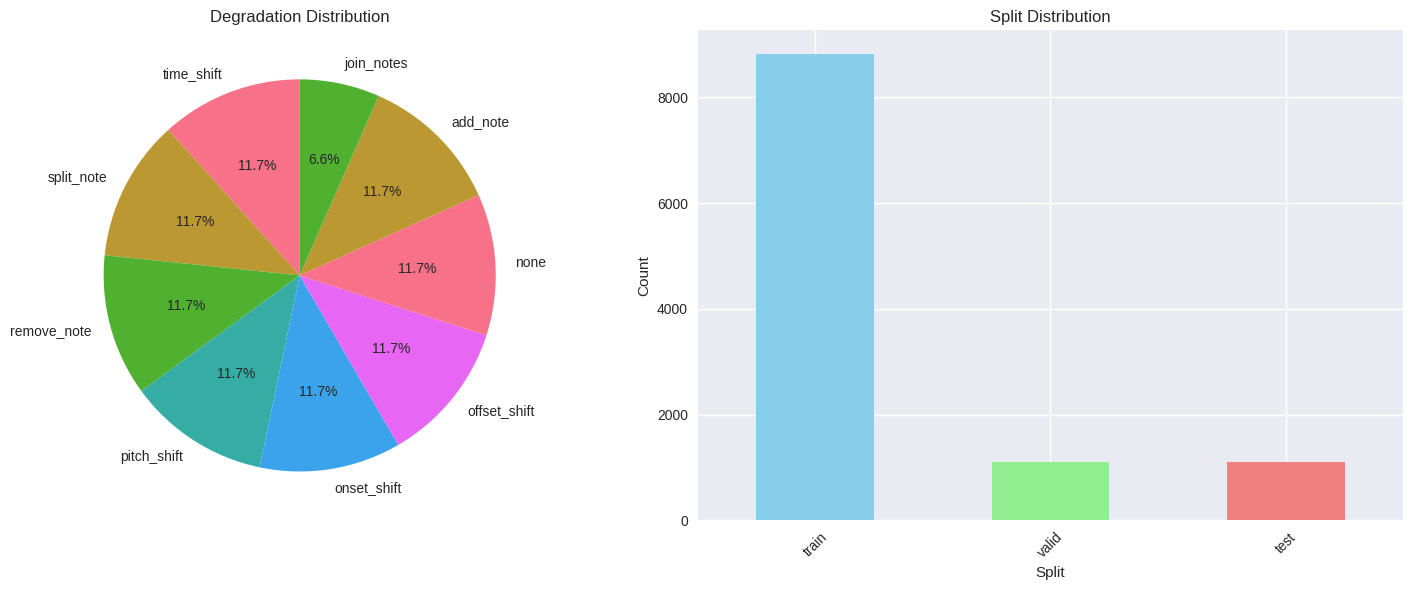

In [34]:
def show_dataset_stats(metadata_df, degradation_map):
    """Display dataset statistics."""
    if metadata_df is None:
        print("No dataset loaded.")
        return

    print("📈 Dataset Statistics")
    print("=" * 50)

    # Basic stats
    print(f"Total file pairs: {len(metadata_df)}")
    print(f"Degraded files: {metadata_df['degraded'].sum()}")
    print(f"Clean files: {(~metadata_df['degraded']).sum()}")

    # Degradation distribution
    print("\n🔧 Degradation Distribution:")
    deg_counts = metadata_df["degradation_name"].value_counts()
    for deg, count in deg_counts.items():
        percentage = (count / len(metadata_df)) * 100
        print(f"  {deg}: {count} ({percentage:.1f}%)")

    # Split distribution
    print("\n📊 Split Distribution:")
    split_counts = metadata_df["split"].value_counts()
    for split, count in split_counts.items():
        percentage = (count / len(metadata_df)) * 100
        print(f"  {split}: {count} ({percentage:.1f}%)")

    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Degradation distribution pie chart
    deg_counts.plot(kind="pie", ax=ax1, autopct="%1.1f%%", startangle=90)
    ax1.set_title("Degradation Distribution")
    ax1.set_ylabel("")

    # Split distribution bar chart
    split_counts.plot(kind="bar", ax=ax2, color=["skyblue", "lightgreen", "lightcoral"])
    ax2.set_title("Split Distribution")
    ax2.set_xlabel("Split")
    ax2.set_ylabel("Count")
    ax2.tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()


# Show dataset statistics
show_dataset_stats(metadata_df, degradation_map)

## Usage Instructions

### How to use this notebook:

1. **Setup**: Make sure you have generated an ACME dataset using `make_dataset.py` with the `--num-variants` option if you want to compare multiple variants.

2. **File Selection**: Use the dropdown menus above to:
   - Select a base file from your dataset
   - Choose a specific variant (if multiple variants were generated)

3. **Comparison**: Click the "Compare Files" button to generate side-by-side piano roll visualizations.

4. **Analysis**: The piano rolls show:
   - **X-axis**: Time in milliseconds
   - **Y-axis**: MIDI pitch numbers
   - **Color**: Note velocity (brightness indicates loudness)
   - **Width**: Note duration

### Understanding the visualizations:

- **Clean version**: Shows the original, unmodified MIDI excerpt
- **Degraded version**: Shows the same excerpt after applying the specified degradation
- **Differences**: Look for changes in timing, pitch, duration, or missing/added notes

### Tips for analysis:

- Compare note densities between clean and degraded versions
- Look for systematic shifts in timing or pitch
- Notice if certain pitch ranges are more affected
- Observe how different degradations affect the musical structure

This tool is particularly useful for:
- Understanding the effects of different degradation functions
- Quality control of generated datasets
- Educational purposes in music information retrieval
- Preparing data for machine learning experiments